In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import time
import warnings
warnings.filterwarnings('ignore')

In [11]:
data_path = "../data/final_hybrid_data/benign_ddos_bf_dataset.csv"
df = pd.read_csv(data_path)

In [12]:
df.head(2)

,Total Length of Bwd Packets,Bwd Packet Length Min,Max Packet Length,Fwd Packet Length Std,Average Packet Size,Total Length of Fwd Packets,RST Flag Count,Down/Up Ratio,Bwd IAT Total,SYN Flag Count,...,ECE Flag Count,Flow IAT Std,Fwd Packet Length Mean,Total Fwd Packets,URG Flag Count,Fwd Packets/s,Init_Win_bytes_backward,Fwd IAT Total,Fwd Header Length,Label
0,0.0,0.0,0.0,0.000000,0.000,0.0,0,0.0,0.0,0,...,0,0.000000,0.0,2,0,14492.753623,-1,138.0,40,0
1,1618.0,0.0,1173.0,228.129662,172.875,1148.0,1,1.0,2950036.0,0,...,1,280149.233266,143.5,8,0,2.580082,62852,3100677.0,172,0


In [13]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Temizleme öncesi satır sayısı: {len(df)}")
df.dropna(inplace=True)
print(f"Temizleme sonrası satır sayısı: {len(df)}")

df.reset_index(drop=True, inplace=True)
print(f"Kalan NaN sayısı: {df.isnull().sum().sum()}")
print(f"Kalan Inf sayısı: {np.isinf(df.select_dtypes(include = np.number)).values.sum()}")

Temizleme öncesi satır sayısı: 1142847
Temizleme sonrası satır sayısı: 1139940
Kalan NaN sayısı: 0
Kalan Inf sayısı: 0


In [15]:
print("Veri Seti İçerisindeki Sınıf Dağılımı:")
print(df['Label'].value_counts())

Veri Seti İçerisindeki Sınıf Dağılımı:
Label
2    380949
1    380946
0    378045
Name: count, dtype: int64


In [16]:
# PREPROCESSING
X = df.drop('Label', axis=1)
y = df['Label']

# Test Size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0, stratify = y)

In [17]:
# Veriyi Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Test Verisini fit_transform yapmıyoruz

In [18]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state = 0),
    "Random Forest": RandomForestClassifier(n_estimators = 100, n_jobs=-1, random_state = 0), # n_jobs=-1 tüm işlemcileri kullanır
    "Logistic Regression": LogisticRegression(max_iter = 1000, n_jobs=-1, random_state = 0),
    
    # Boosting Modelleri
    "XGBoost": XGBClassifier(
        eval_metric = 'mlogloss', 
        use_label_encoder = False, 
        n_jobs = -1, 
        random_state = 0
    ),
    "LightGBM": LGBMClassifier(
        n_jobs = -1, 
        random_state = 0, 
        verbose = -1 # loglar kapalı
    ),
    "CatBoost": CatBoostClassifier(
        verbose = 0, # loglar kapalı
        random_state = 42,
        thread_count = -1
    )
}

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score", "CV Mean Score", "Time"])

In [19]:
print(f"{'-'*20} EĞİTİM BAŞLIYOR {'-'*20}")
print(f"Toplam Veri Sayısı: {len(df)}")
print(f"Modeller: {', '.join(models.keys())}\n")

# EĞİTİM DÖNGÜSÜ
for name, model in models.items():
    start_time = time.time()
    
    # Boosting ve Ağaçlar için ölçeklenmemiş, LogReg için ölçeklenmiş veri kullanalıyorum
    # Not: Boosting algoritmaları ölçekli veriyle de gayet iyi çalışır.
    if name == "Logistic Regression":
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
        
    # Model eğitimi
    model.fit(X_tr, y_train)
    
    # Tahmin
    y_pred = model.predict(X_te)
    
    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    # Cross Validation 
    # 1 Milyondan fazla satır olduğu için cv 3'e düşürüldü
    cv_scores = cross_val_score(model, X_tr, y_train, cv = 3, scoring = 'f1_macro', n_jobs = -1)
    cv_mean = cv_scores.mean()
    
    elapsed_time = time.time() - start_time
    
    # Kayıtlar
    new_row = pd.DataFrame({
        "Model": [name], "Accuracy": [acc], "Precision": [prec], 
        "Recall": [rec], "F1-Score": [f1], "CV Mean Score": [cv_mean],
        "Time (s)": [round(elapsed_time, 2)]
    })
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    
    print(f"Model Tamamlandı: {name} (Süre: {elapsed_time:.2f}sn)")

# SONUÇLARI SIRALA VE GÖSTER
results_df = results_df.sort_values(by = "F1-Score", ascending = False).reset_index(drop = True) # F1-Score'a göre model sıralaması

-------------------- EĞİTİM BAŞLIYOR --------------------
Toplam Veri Sayısı: 1139940
Modeller: Decision Tree, Random Forest, Logistic Regression, XGBoost, LightGBM, CatBoost

Model Tamamlandı: Decision Tree (Süre: 41.64sn)
Model Tamamlandı: Random Forest (Süre: 165.98sn)
Model Tamamlandı: Logistic Regression (Süre: 78.08sn)
Model Tamamlandı: XGBoost (Süre: 39.02sn)
Model Tamamlandı: LightGBM (Süre: 24.54sn)
Model Tamamlandı: CatBoost (Süre: 517.38sn)


In [20]:
print("\n" + "="*60)
print("PERFORMANS SIRALAMASI (F1-SCORE BAZLI)")
print("="*60)
print(results_df)


PERFORMANS SIRALAMASI (F1-SCORE BAZLI)
                 Model  Accuracy  Precision    Recall  F1-Score  \
0             LightGBM  0.999877   0.999877  0.999877  0.999877   
1              XGBoost  0.999877   0.999877  0.999877  0.999877   
2        Random Forest  0.999816   0.999815  0.999816  0.999816   
3             CatBoost  0.999789   0.999789  0.999789  0.999789   
4        Decision Tree  0.999711   0.999710  0.999710  0.999710   
5  Logistic Regression  0.984955   0.985083  0.984909  0.984929   

   CV Mean Score Time  Time (s)  
0       0.999881  NaN     24.54  
1       0.999867  NaN     39.02  
2       0.999768  NaN    165.98  
3       0.999822  NaN    517.38  
4       0.999677  NaN     41.64  
5       0.984478  NaN     78.08  



En İyi Model: LightGBM ile görselleştirme yapılıyor...


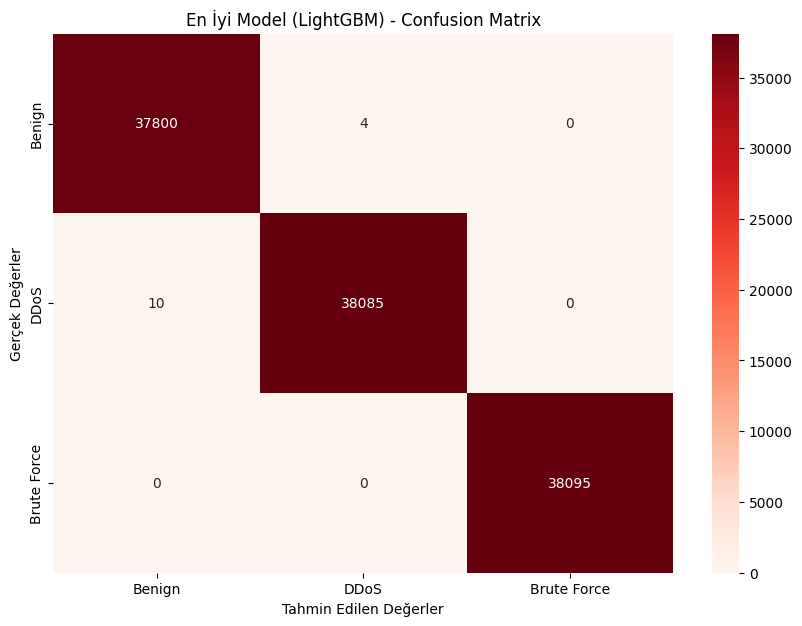

In [21]:
# En iyi modeli seçip confusion matrixine bir bakalım
best_model_name = results_df.iloc[0]["Model"]

print(f"\nEn İyi Model: {best_model_name} ile görselleştirme yapılıyor...")

best_model = models[best_model_name]

# Log Reg modeline scaled veri vermiştik onu unutmayalım
if best_model_name == "Logistic Regression":
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test) # Diğer modeller scaled olmasa da çalışır

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Benign', 'DDoS', 'Brute Force'], 
            yticklabels=['Benign', 'DDoS', 'Brute Force'])
plt.title(f'En İyi Model ({best_model_name}) - Confusion Matrix')
plt.ylabel('Gerçek Değerler')
plt.xlabel('Tahmin Edilen Değerler')
plt.show()

In [23]:
results_df.drop(columns = 'Time')

,Model,Accuracy,Precision,Recall,F1-Score,CV Mean Score,Time (s)
0,LightGBM,0.999877,0.999877,0.999877,0.999877,0.999881,24.54
1,XGBoost,0.999877,0.999877,0.999877,0.999877,0.999867,39.02
2,Random Forest,0.999816,0.999815,0.999816,0.999816,0.999768,165.98
3,CatBoost,0.999789,0.999789,0.999789,0.999789,0.999822,517.38
4,Decision Tree,0.999711,0.999710,0.999710,0.999710,0.999677,41.64
5,Logistic Regression,0.984955,0.985083,0.984909,0.984929,0.984478,78.08



 MODELLERE GÖRE EN ÖNEMLİ 10 ÖZELLİK

--- Decision Tree ---
Destination Port               : 0.48368
Init_Win_bytes_backward        : 0.26243
Init_Win_bytes_forward         : 0.19147
Flow IAT Min                   : 0.02502
Fwd Packets/s                  : 0.00991
Flow IAT Max                   : 0.00880
Bwd Packets/s                  : 0.00748
Total Fwd Packets              : 0.00587
Fwd Packet Length Mean         : 0.00069
Bwd Packet Length Max          : 0.00063

--- Random Forest ---
Init_Win_bytes_forward         : 0.12705
Destination Port               : 0.11401
Init_Win_bytes_backward        : 0.06374
Flow Duration                  : 0.05757
Bwd Packets/s                  : 0.05489
Flow IAT Mean                  : 0.04705
Flow IAT Max                   : 0.04585
Bwd Header Length              : 0.03687
Fwd Packets/s                  : 0.03337
Fwd Header Length              : 0.03307

--- Logistic Regression ---
Fwd Packets/s                  : 27.64291
Flow Packets/s           

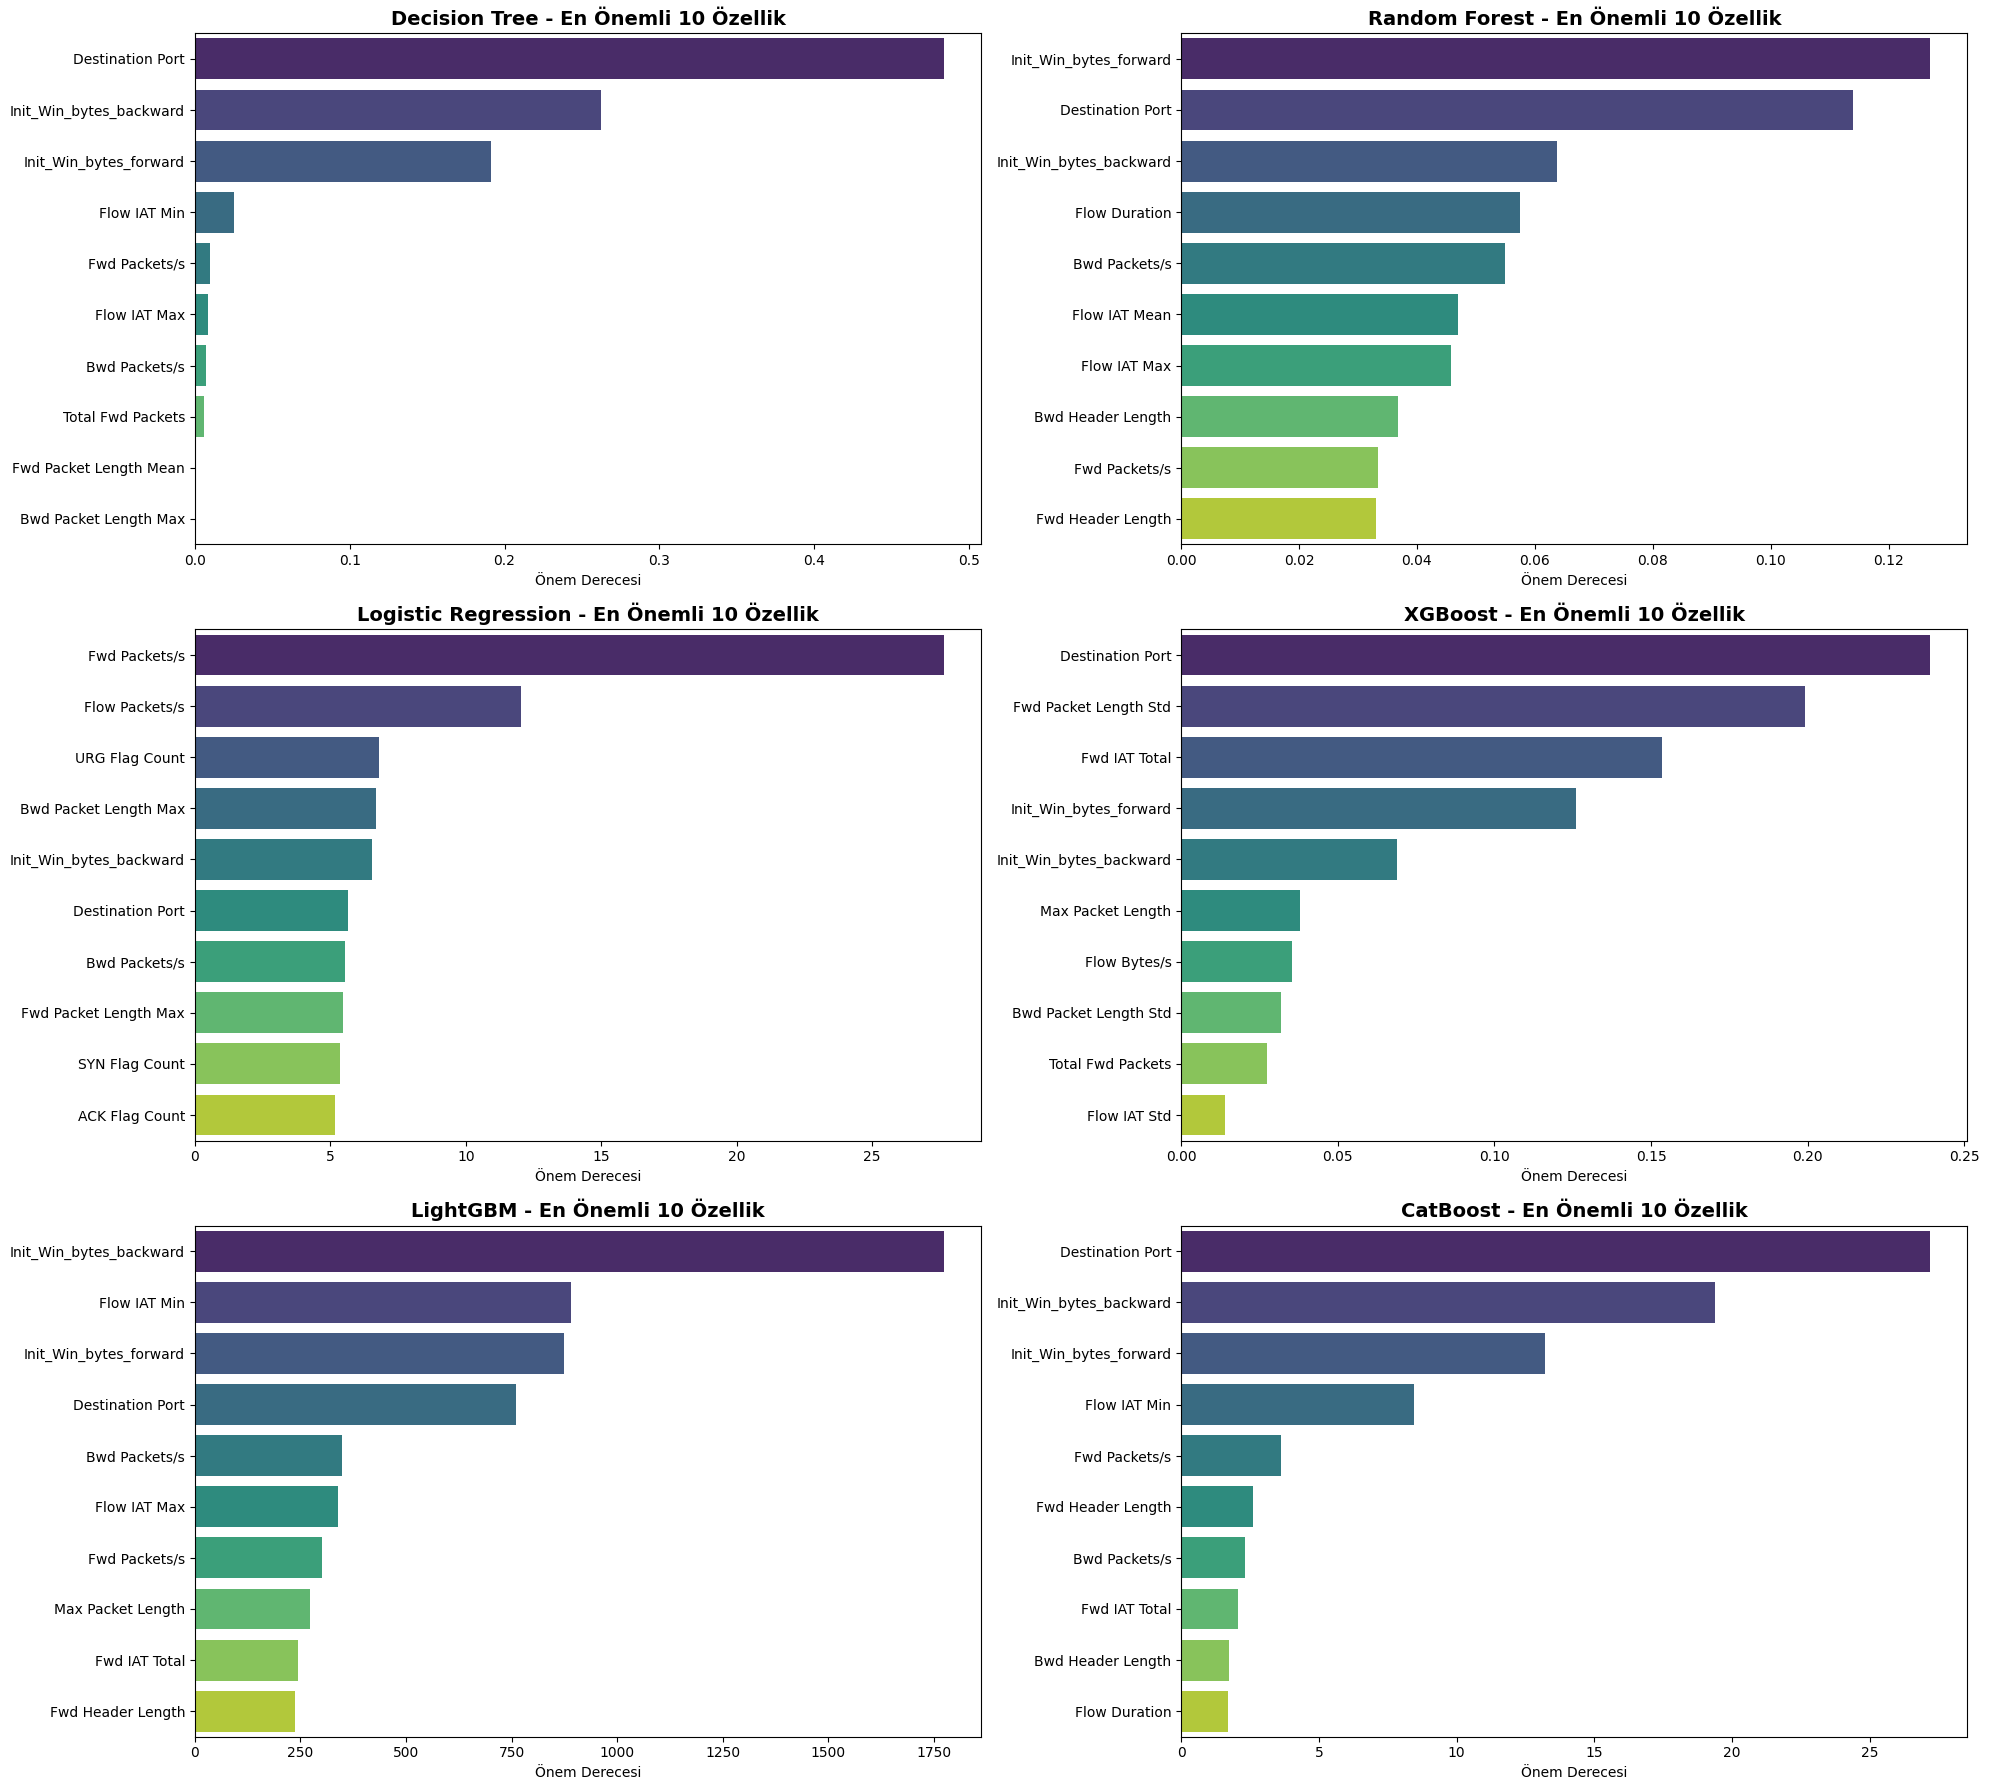

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))
axes = axes.flatten()

feature_names = X.columns

print("\n" + "="*40)
print(" MODELLERE GÖRE EN ÖNEMLİ 10 ÖZELLİK")
print("="*40)

for i, (name, model) in enumerate(models.items()):
    # Önem Değerlerini Çekme
    try:
        if name == "Logistic Regression":
            # Logistic Regression katsayı kullanır.
            # 3 sınıf olduğu için katsayıların mutlak değerlerinin ortalamasını alıyoruz.
            importances = np.mean(np.abs(model.coef_), axis=0)
        elif name == "CatBoost":
            importances = model.get_feature_importance()
        else:
            # Diğer ağaç tabanlı modeller için fonksiyon ismi aynı
            importances = model.feature_importances_
            
        # DataFrame Oluşturma ve Sıralama İşlemi
        feature_imp_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        })
        
        # En yüksek 10 özelliği seçiyoruz
        top_10 = feature_imp_df.sort_values(by = 'Importance', ascending = False).head(10)
        
        # Yazılı Çıktılar
        print(f"\n--- {name} ---")
        for index, row in top_10.iterrows():
            print(f"{row['Feature']:<30} : {row['Importance']:.5f}")
            
        # Görselleştirme
        sns.barplot(x='Importance', y='Feature', data = top_10, ax = axes[i], palette = 'viridis')
        axes[i].set_title(f'{name} - En Önemli 10 Özellik', fontsize = 14, fontweight = 'bold')
        axes[i].set_xlabel('Önem Derecesi')
        axes[i].set_ylabel('')
        
    except Exception as e:
        print(f"{name} için feature importance hesaplanamadı: {e}")
        # Hata durumunda boş grafiği gizleyecek
        axes[i].axis('off')

plt.tight_layout()
plt.show()

In [25]:
X.columns

Index(['Total Length of Bwd Packets', 'Bwd Packet Length Min',
       'Max Packet Length', 'Fwd Packet Length Std', 'Average Packet Size',
       'Total Length of Fwd Packets', 'RST Flag Count', 'Down/Up Ratio',
       'Bwd IAT Total', 'SYN Flag Count', 'PSH Flag Count',
       'Packet Length Mean', 'Flow IAT Max', 'Bwd Packet Length Std',
       'Destination Port', 'Packet Length Variance', 'Bwd Packets/s',
       'Bwd Header Length', 'Packet Length Std', 'Fwd Packet Length Max',
       'FIN Flag Count', 'Min Packet Length', 'Bwd Packet Length Mean',
       'Fwd Packet Length Min', 'Flow IAT Mean', 'Flow Duration',
       'Bwd Packet Length Max', 'Flow Packets/s', 'Total Backward Packets',
       'Flow Bytes/s', 'Flow IAT Min', 'Init_Win_bytes_forward',
       'ACK Flag Count', 'ECE Flag Count', 'Flow IAT Std',
       'Fwd Packet Length Mean', 'Total Fwd Packets', 'URG Flag Count',
       'Fwd Packets/s', 'Init_Win_bytes_backward', 'Fwd IAT Total',
       'Fwd Header Length'],
      d

In [26]:
selected_features = [
    'Destination Port', 
    'Init_Win_bytes_forward', 
    'Init_Win_bytes_backward', 
    'Fwd Header Length', 
    'Max Packet Length', 
    'Flow IAT Min', 
    'Flow IAT Max', 
    'Fwd Packets/s', 
    'Bwd Packets/s', 
    'Fwd Packet Length Std' 
]

In [28]:
available_features = [f for f in selected_features if f in df.columns]
if len(available_features) < 10:
    print("UYARI: Bazı özellikler veri setinde bulunamadı. Lütfen sütun isimlerini kontrol et.")
    print(f"Bulunanlar: {available_features}")
else:
    print(f"Seçilen 10 Özellik: {available_features}")


X_lite = df[available_features]
y_lite = df['Label']

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_lite, y_lite, test_size = 0.1, random_state = 0, stratify = y_lite)

Seçilen 10 Özellik: ['Destination Port', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward', 'Fwd Header Length', 'Max Packet Length', 'Flow IAT Min', 'Flow IAT Max', 'Fwd Packets/s', 'Bwd Packets/s', 'Fwd Packet Length Std']


In [29]:
print("\nLightGBM Lite Eğitiliyor...")
start_time = time.time()

lgbm_lite = LGBMClassifier(n_jobs = -1, random_state = 0, verbose=-1)
lgbm_lite.fit(X_train_l, y_train_l)

elapsed_time = time.time() - start_time

# PERFORMANS METRİKLERİ
y_pred_l = lgbm_lite.predict(X_test_l)

acc = accuracy_score(y_test_l, y_pred_l)
f1 = f1_score(y_test_l, y_pred_l, average='macro')
prec = precision_score(y_test_l, y_pred_l, average='macro')
rec = recall_score(y_test_l, y_pred_l, average='macro')

# Cross Validation 3 Katlı
cv_scores = cross_val_score(lgbm_lite, X_train_l, y_train_l, cv = 3, scoring='f1_macro', n_jobs = -1)
cv_mean = cv_scores.mean()

# SONUÇ RAPORU
print("-" * 50)
print(f"MODEL: LightGBM (Sadece 10 Özellik)")
print("-" * 50)
print(f"Eğitim Süresi : {elapsed_time:.2f} saniye")
print(f"Accuracy      : {acc:.6f}")
print(f"F1-Score      : {f1:.6f}")
print(f"Precision     : {prec:.6f}")
print(f"Recall        : {rec:.6f}")
print(f"CV Mean Score : {cv_mean:.6f}")
print("-" * 50)

print("\nClassification Report:\n")
print(classification_report(y_test_l, y_pred_l, target_names=['Benign', 'DDoS', 'Brute Force']))


LightGBM Lite Eğitiliyor...
--------------------------------------------------
MODEL: LightGBM (Sadece 10 Özellik)
--------------------------------------------------
Eğitim Süresi : 4.09 saniye
Accuracy      : 0.999842
F1-Score      : 0.999842
Precision     : 0.999842
Recall        : 0.999842
CV Mean Score : 0.999873
--------------------------------------------------

Classification Report:

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     37804
        DDoS       1.00      1.00      1.00     38095
 Brute Force       1.00      1.00      1.00     38095

    accuracy                           1.00    113994
   macro avg       1.00      1.00      1.00    113994
weighted avg       1.00      1.00      1.00    113994



In [30]:
import joblib
import os

save_path = "../models/MultiClass_Models/Model/benign_ddos_bf_model.pkl"

joblib.dump(lgbm_lite, save_path)

print(f"Model başarıyla '{save_path}' olarak kaydedildi.")

Model başarıyla '../models/MultiClass_Models/Model/benign_ddos_bf_model.pkl' olarak kaydedildi.
